In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import json
import numpy as np

from attn_contrib import *

/home/rseetharaman_umass_edu/.conda/envs/rome/lib/python3.9/site-packages/transformers/utils/generic.py:485: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
device = torch.device("cuda")

In [4]:
class AttnWrapper(torch.nn.Module):
    def __init__(self, attn):
        super().__init__()
        self.attn = attn
        self.activations = None
        self.add_tensor = None

    def forward(self, *args, **kwargs):
        output = self.attn(*args, **kwargs)
        if self.add_tensor is not None:
            output = (output[0] + self.add_tensor,)+output[1:]
        self.activations = output[0]
        return output

    def reset(self):
        self.activations = None
        self.add_tensor = None
    

class BlockOutputWrapper(torch.nn.Module):
    def __init__(self, block, unembed_matrix, norm):
        super().__init__()
        self.block = block
        self.unembed_matrix = unembed_matrix
        self.norm = norm

        self.block.self_attn = AttnWrapper(self.block.self_attn)
        self.post_attention_layernorm = self.block.post_attention_layernorm

        self.attn_mech_output_unembedded = None
        self.intermediate_res_unembedded = None
        self.mlp_output_unembedded = None
        self.block_output_unembedded = None


    def forward(self, *args, **kwargs):
        output = self.block(*args, **kwargs)
        self.block_output_unembedded = self.unembed_matrix(self.norm(output[0]))
        attn_output = self.block.self_attn.activations
        self.attn_mech_output_unembedded = self.unembed_matrix(self.norm(attn_output))
        attn_output += args[0]
        self.intermediate_res_unembedded = self.unembed_matrix(self.norm(attn_output))
        mlp_output = self.block.mlp(self.post_attention_layernorm(attn_output))
        self.mlp_output_unembedded = self.unembed_matrix(self.norm(mlp_output))
        return output

    def attn_add_tensor(self, tensor):
        self.block.self_attn.add_tensor = tensor

    def reset(self):
        self.block.self_attn.reset()

    def get_attn_activations(self):
        return self.block.self_attn.activations

In [5]:
class Mistral7BHelper:
    def __init__(self, model, tokenizer, device=torch.device("cuda")):
        self.device = device
        self.tokenizer = tokenizer
        self.model = model
        for i, layer in enumerate(self.model.model.layers):
            self.model.model.layers[i] = BlockOutputWrapper(layer, self.model.lm_head, self.model.model.norm)

    def generate_text(self, prompt, max_length=100):
        inputs = self.tokenizer(prompt, return_tensors="pt")
        generate_ids = self.model.generate(inputs.input_ids.to(self.device), max_length=max_length)
        return self.tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]

    def get_logits(self, prompt):
        inputs = self.tokenizer(prompt, return_tensors="pt")
        with torch.no_grad():
          sequence_output = self.model(inputs.input_ids.to(self.device))
          logits = sequence_output.logits
          return logits
        
    def get_attention_probabilities(self, prompt):
        inputs = self.tokenizer(prompt, return_tensors="pt")
        with torch.no_grad():
          sequence_output = self.model(inputs.input_ids.to(self.device))
          attentions = sequence_output.attentions
          return attentions

    def set_add_attn_output(self, layer, add_output):
        self.model.model.layers[layer].attn_add_tensor(add_output)

    def get_attn_activations(self, layer):
        return self.model.model.layers[layer].get_attn_activations()

    def reset_all(self):
        for layer in self.model.model.layers:
            layer.reset()

    def print_decoded_activations(self, decoded_activations, label):
        softmaxed = torch.nn.functional.softmax(decoded_activations[0][-1], dim=-1)
        values, indices = torch.topk(softmaxed, 10)
        probs_percent = [int(v * 100) for v in values.tolist()]
        tokens = self.tokenizer.batch_decode(indices.unsqueeze(-1))
        print(label, list(zip(tokens, probs_percent)))
    
    def decode_all_layers(self, text, subject, attribute):
        attr_positions = find_token_range(self.tokenizer, text, attribute)
        indexes = []
        for s,e in attr_positions:
            indexes.extend(list(range(s, e)))
        subj_start, subj_end = find_token_range(self.tokenizer, text, subject)[-1]
        attentions = self.get_attention_probabilities(text)
        norms = []
        for i, layer in enumerate(self.model.model.layers):
            attn_activations = layer.block.self_attn.activations
            attn_at_layer = attentions[i][0]
            embeddings = attn_activations[:, indexes, :].squeeze(0)
            probs = attn_at_layer[:, -1, indexes].squeeze(0)
            weighted_embeddings = torch.matmul(probs, embeddings)
            norm = torch.sum(torch.linalg.vector_norm(weighted_embeddings, dim=1))
            norms.append(norm.item())
        return norms


In [6]:
device = torch.device("cuda")
modelname = "mistralai/Mistral-7B-Instruct-v0.1"
model = AutoModelForCausalLM.from_pretrained(modelname, 
                                            output_attentions=True, 
                                            cache_dir="/work/pi_dhruveshpate_umass_edu/rseetharaman_umass_edu/.cache",
                                            return_dict_in_generate=True).to(device)
tokenizer = AutoTokenizer.from_pretrained(modelname, cache_dir="/work/pi_dhruveshpate_umass_edu/rseetharaman_umass_edu/.cache")

/home/rseetharaman_umass_edu/.conda/envs/rome/lib/python3.9/site-packages/transformers/utils/generic.py:342: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/rseetharaman_umass_edu/.conda/envs/rome/lib/python3.9/site-packages/transformers/utils/generic.py:342: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [7]:
model_helper = Mistral7BHelper(model, tokenizer)

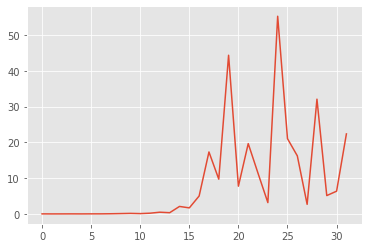

In [8]:
prompt = '''Answer the question solely based on the context.

Context:

Windows Media Player, a creation of Microsoft, has been a cornerstone in digital media playback since its introduction in 1991. Embedded within the Windows suite, it swiftly gained popularity for its intuitive interface and adaptability, becoming the default choice for numerous Windows users worldwide. Its seamless integration with the Windows ecosystem facilitates easy playback of various media formats, including audio, video, and streaming content.

An essential feature of Windows Media Player is its broad compatibility with diverse file formats, ranging from MP3 to WMV and even newer formats like AAC. This versatility ensures smooth playback and a seamless user experience, allowing users to enjoy their multimedia content without worrying about compatibility issues. Furthermore, its robust codec support enables high-definition video playback and immersive audio experiences, enhancing overall entertainment value.

Microsoft has continuously updated Windows Media Player to keep pace with technological advancements and user expectations. Each iteration introduces new features and enhancements, such as visualizations, equalizer settings, and playlist management tools, to improve functionality and user satisfaction. These updates ensure that Windows Media Player remains a reliable and feature-rich media playback solution for users across different Windows versions.

Despite facing competition from third-party media players and streaming services, Windows Media Player retains its popularity due to its reliability, familiarity, and seamless integration with the Windows operating system. Its enduring appeal lies in its user-friendly interface, robust features, and broad format support, making it a preferred choice for millions seeking a straightforward yet powerful media playback solution.


Question:
Who is the creator of Windows Media Player ?
Answer is'''

subject="WindowsMediaPlayer"
attribute = "Microsoft"

norms = model_helper.decode_all_layers(prompt, subject, attribute)
plt.plot(range(len(norms)), norms)

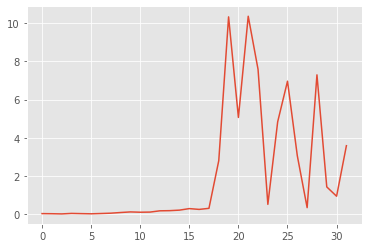

In [9]:
prompt = '''Answer the question solely based on the context.

Context:

Wayne Rooney, a name synonymous with English football, has left an indelible mark on the sport both domestically and internationally. Born on October 24, 1985, in Liverpool, England, Rooney showed promise from a young age, quickly rising through the ranks to become one of the most recognized footballers of his generation. His journey began with Everton FC, where his exceptional talent caught the eye of scouts and fans alike. 

Professionally, Wayne Rooney's career has been nothing short of illustrious. With an unparalleled work ethic and a knack for scoring crucial goals, he has graced the pitches of top-tier clubs, including Manchester United and D.C. United. Rooney's tenure at Manchester United, where he spent the majority of his club career, saw him become the club's all-time leading goal scorer, surpassing legends such as Bobby Charlton. His contributions were instrumental in securing numerous trophies, including Premier League titles and the UEFA Champions League.

Beyond his club exploits, Wayne Rooney's impact extends to the international stage. Representing England, he earned over a century of caps, making him one of the most capped players in the nation's history. Rooney's performances in major tournaments, such as the FIFA World Cup and the UEFA European Championship, showcased his versatility, leadership, and unparalleled skill on the field. Despite the challenges faced by the England team during his era, Rooney's passion and commitment never wavered, earning him the admiration of fans worldwide.

Off the field, Wayne Rooney's influence transcends the boundaries of the sport. As a role model and ambassador, he has used his platform to champion charitable causes and support initiatives aimed at enhancing the lives of others. Rooney's dedication to philanthropy underscores his belief in giving back to the community and using his status for the greater good. Whether on the pitch or off it, Wayne Rooney continues to inspire generations of football enthusiasts, leaving an enduring legacy that extends far beyond the realm of sports.

Question:
What sport does Rooney play professionally ?
Answer is'''


subject = "Rooney"
attribute = "football"

norms = model_helper.decode_all_layers(prompt, subject, attribute)
plt.plot(range(len(norms)), norms)

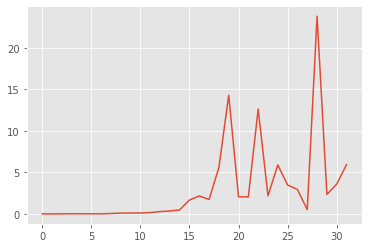

In [10]:
prompt = '''Answer the question solely based on the context.

Context:

At CAC, students benefit from a comprehensive educational experience that emphasizes critical thinking, creativity, and collaboration. The school's dedicated faculty members are passionate about inspiring a love for learning and nurturing the unique talents of each student. With small class sizes and personalized attention, CAC ensures that every student receives the support they need to thrive academically and personally.

Beyond academics, CAC offers a wide range of extracurricular activities and programs that enrich students' educational journey. From athletics and performing arts to community service and leadership opportunities, students have ample opportunities to explore their interests, develop new skills, and forge lifelong friendships with peers from around the world.

Cairo American College (CAC) stands as a beacon of academic excellence and cultural diversity in Egypt's capital city. Established in 1945, CAC has a rich history of providing a rigorous American curriculum to students from diverse backgrounds, fostering a vibrant learning community that prepares students for success in a globalized world.

CAC's commitment to fostering a diverse and inclusive community is evident in its student body, which comprises individuals from over 60 nationalities. This rich tapestry of cultures, languages, and perspectives creates a dynamic learning environment where students learn to appreciate and respect differences while celebrating the shared values that unite them as global citizens.

As a leading international school in Cairo, CAC continues to uphold its mission of empowering students to become compassionate, lifelong learners who make positive contributions to society. With a steadfast dedication to excellence and a forward-thinking approach to education, CAC remains at the forefront of preparing the leaders of tomorrow for the challenges and opportunities of an ever-changing world.

Question:
Cairo American College is located in the country of ?
Answer is'''


subject = "CairoAmericanCollege"
attribute = "Egypt"


norms = model_helper.decode_all_layers(prompt, subject, attribute)
plt.plot(range(len(norms)), norms)

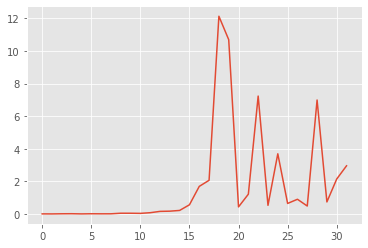

In [22]:
prompt = '''Answer the question solely based on the context.

Context:

The attack on Charlie Hebdo sparked global outrage and ignited debates surrounding the boundaries of free speech, religious sensitivities, and the role of satire in society. Many defended the magazine's right to express opinions and criticize without fear of violent reprisal, while others called for more sensitivity in the portrayal of religious figures and beliefs. The hashtag #JeSuisCharlie ("I am Charlie") became a rallying cry for supporters worldwide, expressing solidarity with the magazine's staff and the principles of free speech.

In the aftermath of the attack, Charlie Hebdo continued its publication, undeterred by the violence. The surviving staff members, despite mourning the loss of their colleagues, remained resolute in their commitment to freedom of expression. The magazine's covers became even more poignant, with powerful messages condemning extremism and advocating for liberty. Charlie Hebdo's defiance in the face of tragedy became a symbol of resilience and a testament to the enduring importance of free speech in democratic societies.

Charlie Hebdo, a French satirical magazine founded in 1970, has been a significant emblem of free speech and political satire. The publication gained international attention, particularly after the tragic events of January 7, 2015. On that day, two gunmen stormed the magazine's office in Paris, killing twelve people and injuring eleven others. The attack was a brutal assault on freedom of expression, as Charlie Hebdo had been known for its provocative cartoons, often lampooning political figures, religions, and ideologies without restraint.

However, the Charlie Hebdo attack also raised questions about security, censorship, and the responsibilities of media outlets. Some argued for increased protection for journalists and artists who risk their lives to uphold free speech, while others cautioned against the potential consequences of inflammatory rhetoric and imagery. The debate over balancing freedom of expression with respect for cultural and religious sensitivities continues to be a complex and contentious issue, with no easy solutions.

Despite the challenges and controversies it has faced, Charlie Hebdo remains an influential voice in the realm of political satire and a steadfast defender of free speech. The magazine's fearless approach to challenging authority and confronting taboos has left an indelible mark on the media landscape, reminding us of the power—and the peril—of speaking truth to power. Charlie Hebdo's legacy serves as a reminder of the ongoing struggle to uphold democratic values and protect the fundamental right to express dissenting opinions, even in the face of adversity.

Question:
Charlie Hebdo is written in which language ?
Answer is'''


subject = "CharlieHebdo"
attribute = "French"


norms = model_helper.decode_all_layers(prompt, subject, attribute)
plt.plot(range(len(norms)), norms)

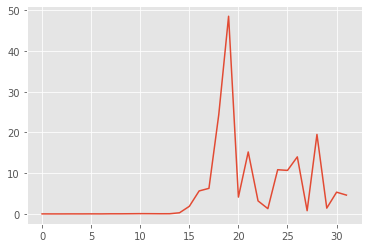

In [11]:
prompt = '''Answer the question solely based on the context.

Context:

Jeremy Paxman is a prominent British journalist, author, and broadcaster, renowned for his incisive interviewing style and sharp wit. Born on May 11, 1950, in Leeds, England, Paxman developed a keen interest in journalism during his formative years. He pursued his education at Cambridge University, where he was actively involved in student journalism, foreshadowing his future career path. Paxman's career took flight when he joined the BBC in the 1970s, marking the beginning of a long and influential tenure with the renowned broadcasting corporation.

One of Paxman's most notable contributions to journalism is his iconic role as the anchor of BBC's flagship news program, "Newsnight." Paxman's tenure on "Newsnight," spanning over two decades, solidified his reputation as one of Britain's foremost political interviewers. His confrontational interviewing style, characterized by relentless questioning and persistent probing, earned him both acclaim and criticism. Paxman's interviews were marked by his ability to hold politicians and public figures to account, often drawing out candid responses and revealing insights into their character and policies.

Beyond his role on "Newsnight," Paxman has authored several books exploring various aspects of British history, politics, and society. His works, including "The English: A Portrait of a People" and "Empire: What Ruling the World Did to the British," reflect his deep intellectual curiosity and passion for understanding the complexities of his homeland's past and present. Paxman's writing style mirrors his on-screen persona—direct, insightful, and occasionally acerbic, yet always engaging.

In addition to his journalistic endeavors, Paxman's influence extends to the realm of academia, where he has served as a visiting fellow and lecturer at prestigious institutions such as Oxford and Harvard. His insights into politics and media have made him a sought-after commentator and speaker on both sides of the Atlantic. Paxman's ability to navigate the intersection of journalism, academia, and public discourse underscores his versatility and enduring relevance in an ever-evolving media landscape.

Despite his retirement from "Newsnight" in 2014, Jeremy Paxman's impact on British journalism and public discourse remains profound. His legacy as a fearless interviewer, insightful commentator, and astute chronicler of British society endures, serving as an inspiration to aspiring journalists and commentators around the world. Whether grilling politicians on live television or delving into the pages of history, Paxman's indelible imprint on British media ensures that his influence will be felt for generations to come.

Question:
Jeremy Paxman is employed by the ?
Answer is'''


subject = "JeremyPaxman"
attribute = "BBC"


norms = model_helper.decode_all_layers(prompt, subject, attribute)
plt.plot(range(len(norms)), norms)

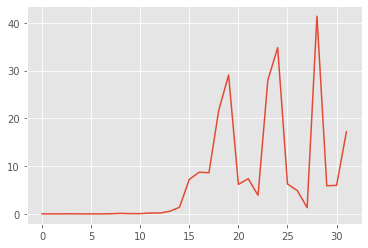

In [24]:
prompt = '''Answer the question solely based on the context.

Context:

Georges Ernest Boulanger, a charismatic and enigmatic figure of French history, emerged as a prominent military leader and political figure during the late 19th century. Born in Rennes, France, in 1837, Boulanger embarked on a military career that would shape his trajectory and cement his place in the annals of French politics. His career took a significant turn when he assumed command in Paris, a city that would become the focal point of his ambitions and controversies.

Working in Paris proved to be a pivotal phase in Boulanger's life and career. As a military officer stationed in the heart of the French capital, he became deeply entrenched in the political landscape of the time. Paris, with its rich history and vibrant intellectual environment, provided Boulanger with a platform to engage with influential figures and shape his own political aspirations. It was here that he began to cultivate a populist appeal, capturing the imagination of the masses with his bold rhetoric and promises of political reform.

Boulanger's tenure in Paris coincided with a period of political upheaval and social unrest in France. The country was grappling with economic challenges, social inequality, and a sense of disillusionment with the ruling elite. In this volatile atmosphere, Boulanger's message of nationalism and anti-establishment sentiment resonated deeply with many disillusioned citizens. His charisma and military background lent him an aura of authority and authenticity that appealed to those disillusioned with traditional politicians.

Despite his military background, Boulanger's ambitions extended beyond the confines of the army. He entered the political arena with fervor, positioning himself as a champion of the people against the entrenched powers of the establishment. His popularity soared, and he quickly amassed a devoted following, known as the Boulangerists, who hailed him as a savior of the nation. However, his meteoric rise to prominence also attracted the attention of his adversaries, who viewed him as a threat to the stability of the republic.

Ultimately, Boulanger's political career was marked by both triumph and tragedy. While he succeeded in galvanizing popular support and challenging the status quo, his ambitions ultimately led to his downfall. Accused of plotting a coup against the government, he was forced into exile, ending his tumultuous journey from the military barracks of Paris to the heights of political power and, ultimately, ignominy. Yet, his legacy endures as a symbol of the complexities and contradictions of French politics during a pivotal period in its history.

Question:
Georges Ernest Boulanger worked in the city of ?
Answer is'''


subject = "GeorgesErnestBoulanger"
attribute = "Paris"


norms = model_helper.decode_all_layers(prompt, subject, attribute)
plt.plot(range(len(norms)), norms)

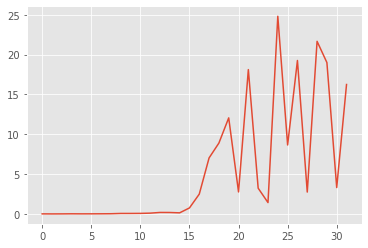

In [14]:
prompt = '''Answer the question solely based on the context.

Context:

Massachusetts Institute of Technology (MIT) stands as a beacon of innovation and academic excellence, nestled in Cambridge, Massachusetts. Renowned worldwide for its cutting-edge research and groundbreaking discoveries, MIT has been at the forefront of technological advancement for over a century. Its campus pulsates with the energy of brilliant minds collaborating to tackle some of the most pressing challenges facing humanity.

At MIT, the pursuit of knowledge knows no bounds. From engineering to economics, from biology to business, every discipline is explored with a spirit of curiosity and a commitment to pushing the boundaries of what is possible. The institute's interdisciplinary approach fosters a rich tapestry of ideas, where diverse perspectives converge to spark new insights and drive progress forward.

Beyond its academic prowess, MIT boasts a vibrant and inclusive community that thrives on intellectual exchange and collaboration. Students from all corners of the globe come together to engage in a dynamic learning environment, where they are empowered to pursue their passions and make a meaningful impact on the world.

Innovation is woven into the fabric of MIT's culture, with entrepreneurship and problem-solving ingrained in its DNA. The institute's renowned labs and research centers serve as incubators for groundbreaking technologies and startups, propelling forward industries ranging from artificial intelligence to renewable energy.

As a beacon of knowledge and a hub of innovation, MIT not only shapes the future through its groundbreaking research but also cultivates the next generation of leaders and visionaries who will continue to push the boundaries of human achievement. With its unwavering commitment to excellence and a spirit of exploration, MIT remains a driving force in shaping the world of tomorrow.

Question: Where is MIT situated ?
Answer is'''

subject = "MIT"
attribute = "Cambridge"

norms = model_helper.decode_all_layers(prompt, subject, attribute)
plt.plot(range(len(norms)), norms)


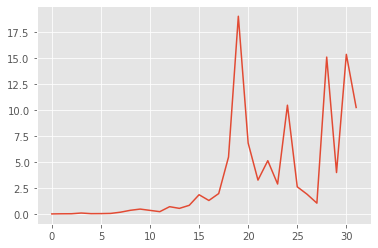

: 

In [17]:
prompt = '''Answer the question solely based on the context.

Context:

"Chennai 600028" is a Tamil-language sports comedy film directed by Venkat Prabhu, released in 2007. Set against the backdrop of gully cricket, the movie captures the essence of friendship, rivalry, and camaraderie among a group of young men living in Chennai's R.A. Puram neighborhood. The film's title refers to the postal code of the area, adding a local touch to its narrative.

The movie follows the journey of two rival cricket teams, Sharks and Rockers, as they engage in intense matches filled with humor, drama, and memorable moments. Through its vibrant characters and witty dialogues, "Chennai 600028" offers a nostalgic trip down memory lane, evoking fond memories of carefree days spent playing street cricket.

One of the film's strengths lies in its authentic portrayal of Chennai's urban landscape and the colorful characters that inhabit it. From the bustling streets to the cricket grounds buzzing with excitement, the movie captures the essence of Chennai's culture and ethos with remarkable accuracy.

"Chennai 600028" received widespread acclaim for its fresh and relatable storyline, lively performances, and catchy music. It struck a chord with audiences of all ages, transcending language barriers to become a cult classic in Tamil cinema.

More than just a sports comedy, "Chennai 600028" is a celebration of friendship, sportsmanship, and the unbreakable bonds that unite people. It continues to be cherished by fans for its timeless appeal and remains a beloved gem in the annals of Tamil cinema.
Question: What language was Chennai 600028 directed in ?
Answer is'''

subject = "Chennai600028"
attribute = "Tamil"

norms = model_helper.decode_all_layers(prompt, subject, attribute)
plt.plot(range(len(norms)), norms)

[]